# 第9章 自然语言处理基础

### 9.1.4 神经网络到有隐含状态的循环神经网络

含隐含状态的循环神经网络的结构如图9-2所示。
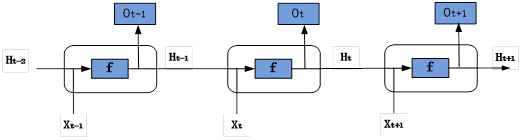
<center>图9-2循环神经网络的结构图</center>  
	每个时间处理的展开，如图9-3所示。

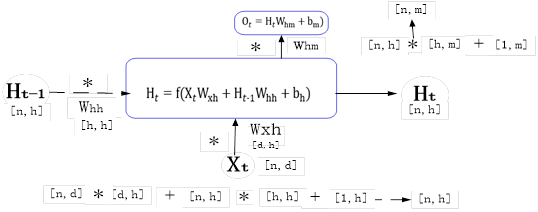
<center>图9-3 循环神经网络每个时间的详细处理逻辑</center>
	假设矩阵X、$W_{xh}$、H和$W_{hh}$，它们的形状分别为 (2，3) 、 (3，4) 、 (2，4) 和 (4，4) 。分别将X乘以$W_{xh}$，将H乘以$W_{hh}$，然后将这两个乘法相加，最后，利用广播机制加上偏移量$B_h$(1,4)，我们得到一个形状为 (2，4) 的$H_t$矩阵。
	假设矩阵$W_{hm}$和$B_m$，它们的形状分别为 (4，2) 、 (1，2)，可得形状为（2,2）的$O_t$矩阵。具体实现过程如下：


In [1]:
import tensorflow as tf

##计算Ht，假设激活函数为ReLU。
X, W_xh = tf.random.normal((2, 3), 0, 1), tf.random.normal((3, 4), 0, 1)
H, W_hh = tf.random.normal((2, 4), 0, 1), tf.random.normal((4, 4), 0, 1)
B_h= tf.random.normal((1, 4), 0, 1)
H1=tf.matmul(X, W_xh) + tf.matmul(H, W_hh)+B_h
H_t=tf.nn.relu(H1)

##计算O_t，输出激活函数为softmax
W_hm= tf.random.normal((4, 2),0, 1)
B_m= tf.random.normal((1, 2),0, 1)
O=tf.matmul(H_t, W_hm) +B_m
O_t=tf.nn.softmax(O, axis=-1)
print("H_t的形状：{}，O_t的形状：{}".format(H_t.shape,O_t.shape))

H_t的形状：(2, 4)，O_t的形状：(2, 2)


当然，也可以使用先对矩阵进行拼接，然后再进行运算，结果是一样的。
沿列（沿列（axis=1）拼接(concatenate)矩阵X和H，得到形状为（2,7）的矩阵[X,H]，沿行（axis=0）拼接矩阵$W_{xh}$和$W_{hh}$,得到形状为（7,4）的矩阵:$\left[\begin{matrix}w_{xh} \cr w_{hh}\end{matrix}\right]$。再将这两个拼接的矩阵相乘,最后与$B_h$相加，得到与上面相同形状的 (2,4) 的输出矩阵。


In [2]:
H01=tf.matmul(tf.concat((X, H), axis=1), tf.concat((W_xh, W_hh), axis=0)) + B_h
H02=tf.nn.relu(H01)
###查看矩阵H_t和H02
print("-"*30+"矩阵H_t"+"-"*30)
print(H_t)
print("-"*30+"矩阵H02"+"-"*30)
print(H02)

------------------------------矩阵H_t------------------------------
tf.Tensor(
[[8.436517  0.        0.        2.1821094]
 [2.4196465 0.9631882 0.        1.5991175]], shape=(2, 4), dtype=float32)
------------------------------矩阵H02------------------------------
tf.Tensor(
[[8.436517   0.         0.         2.1821098 ]
 [2.4196463  0.96318805 0.         1.5991174 ]], shape=(2, 4), dtype=float32)


## 9.2 正向传播与随时间反向传播

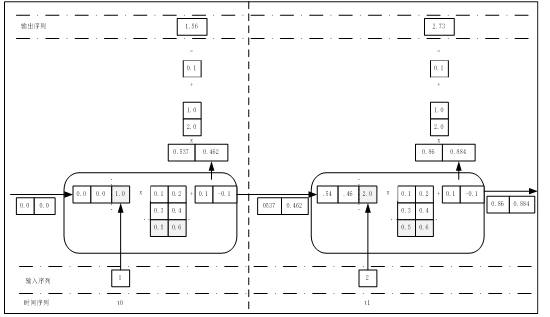

上图表示正向传播（详细内容请参考书中9.2小节内容），用python代码实现如下：

In [3]:
import numpy as np

X = [1,2]
state = [0.0, 0.0]
w_cell_state = np.asarray([[0.1, 0.2], [0.3, 0.4],[0.5, 0.6]])
b_cell = np.asarray([0.1, -0.1])
w_output = np.asarray([[1.0], [2.0]])
b_output = 0.1

for i in range(len(X)):
    state=np.append(state,X[i])
    before_activation = np.dot(state, w_cell_state) + b_cell
    state = np.tanh(before_activation)
    final_output = np.dot(state, w_output) + b_output
    print("状态值_%i: "%i, state)
    print("输出值_%i: "%i, final_output)

状态值_0:  [0.53704957 0.46211716]
输出值_0:  [1.56128388]
状态值_1:  [0.85973818 0.88366641]
输出值_1:  [2.72707101]


## 9.6 循环神经网络实践
这节将通过几个具体实例加深大家对循环网络、卷积神经网络的理解和应用。
### 9.6.1 使用LSTM实现文本分类

1）导入需要的库并设定一些超参数。

In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# 为简便起见，这里只考虑前20000万个单词
max_features = 20000  
# 只考虑每条评论的前200个单词
maxlen = 200  

2）加载数据。这里使用keras的数据加载函数，加载imdb数据集。

In [5]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\wumgapp\Anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\wumgapp\Anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

25000 Training sequences
25000 Validation sequences


3）构建模型。

In [6]:
# 输入为可变长度
inputs = keras.Input(shape=(None,), dtype="int32")
# 把输入转换为长度为128的嵌入向量
x = layers.Embedding(max_features, 128)(inputs)
# 添加两个双向的LSTM
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
#添加一个全连接层，用于分类
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


4）训练及评估模型。

In [7]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))

Epoch 1/2
782/782 [==============================] - 66s 76ms/step - loss: 0.4878 - accuracy: 0.7507 - val_loss: 0.4011 - val_accuracy: 0.8165
Epoch 2/2
782/782 [==============================] - 58s 74ms/step - loss: 0.2386 - accuracy: 0.9089 - val_loss: 0.3943 - val_accuracy: 0.8296


从运行来看，迭代2次精度就达到82%，说明LSTM网络效果不错。